## 思路框架
- 使用normal数据训练预测充放电的t+R的transformer模型
- 将预测的结果和实际结果的mse作为异常score
- 将超过异常score阈值的结果验证打了异常标签的车辆

In [1]:
### 1. 清洗normal数据，分为充电和放电，窗口大小为L，预测长度为R（L指的是SOC百分比）
### X shape: batch_size*time_len*112 Y shape:

In [2]:
from typing import Any
from torch.utils.data import DataLoader, Dataset
from config import *
import polars as pl
import os
import torch
import torch.nn.functional as F
from data_process_pl import make_label, target_car_dict, get_cycle_charge
import matplotlib.pyplot as plt
from data_process_pl import *

In [7]:
df_charge = get_charge_data("D3")
df_charge = make_label(df_charge, target_car_dict['D3'])
df_charge = preprocess(df_charge)

In [26]:
def select_range(df, start, end):
    return df.filter(pl.col('D24_int').is_between(start, end))

In [30]:
tmp = df_charge.filter(pl.col('cycle')==1)
s = tmp['D24_int'].min()
e = tmp['D24_int'].max()

In [ ]:
for i in df_charge['cycle'].unique():
    tmp = df_charge.filter(pl.col('cycle')==i)
    s = tmp['D24_int'].min()
    e = tmp['D24_int'].max()
    if e-s < 10: continue
    for j in range(s, e-4):
        res = select_range(tmp, j, j+5)
        print(f"mode: {res['D19'].value_counts()}")
        print(f"cycle:{i}, range:{j},{j+5}, shape:{res.shape[0]}")

In [88]:
target_car_dict = {'D3':'2022-07-28',
                   'D2':'2022-05-20',
                   'D4':'2022-07-25',
                  'D1':'2022-03-14',
                  'D13':'2022-08-03',
                  'D440':'2022-09-06',
                  'D441':'2022-09-13',
                  'D442':'2022-11-21',
                  'D443':'2022-11-17'}

In [93]:
df_neg1 = pl.read_parquet('processed_data/D280_4_5.parquet')
df_neg2 = pl.read_parquet('processed_data/D246_4_5.parquet')
df_neg3 = pl.read_parquet('processed_data/D296_4_5.parquet')
df_pos = pl.read_parquet('processed_data/D3_4_5.parquet')

In [45]:
print(df.columns)

['D141', 'D22', 'D24_int', 'D44', 'D40', 'D41', 'D52', 'D117', 'D133', 'D334', 'D356', 'D290', 'D135_diff', 'D136_diff', 'soc_diff', 'D135_1', 'D135_2', 'D135_3', 'D135_4', 'D135_5', 'D135_6', 'D135_7', 'D135_8', 'D135_9', 'D135_10', 'D135_11', 'D135_12', 'D135_13', 'D135_14', 'D135_15', 'D135_16', 'D135_17', 'D135_18', 'D135_19', 'D135_20', 'D135_21', 'D135_22', 'D135_23', 'D135_24', 'D135_25', 'D135_26', 'D135_27', 'D135_28', 'D135_29', 'D135_30', 'D135_31', 'D135_32', 'D135_33', 'D135_34', 'D135_35', 'D135_36', 'D135_37', 'D135_38', 'D135_39', 'D135_40', 'D135_41', 'D135_42', 'D135_43', 'D135_44', 'D135_45', 'D135_46', 'D135_47', 'D135_48', 'D135_49', 'D135_50', 'D135_51', 'D135_52', 'D135_53', 'D135_54', 'D135_55', 'D135_56', 'D135_57', 'D135_58', 'D135_59', 'D135_60', 'D135_61', 'D135_62', 'D135_63', 'D135_64', 'D135_65', 'D135_66', 'D135_67', 'D135_68', 'D135_69', 'D135_70', 'D135_71', 'D135_72', 'D135_73', 'D135_74', 'D135_75', 'D135_76', 'D135_77', 'D135_78', 'D135_79', 'D135_8

In [52]:
## 入选特征： [f"D135_{i}_dv" for i in range(1,113)], ['D135_diff_max','D135_std_max']

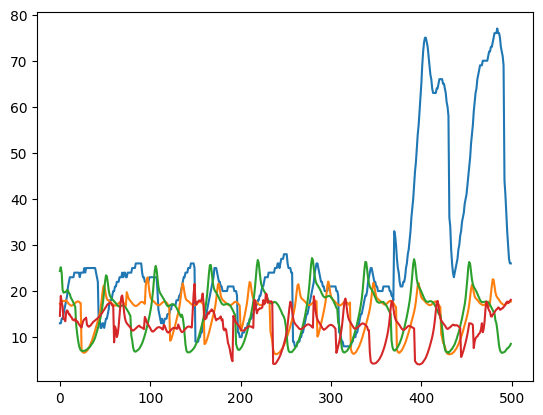

In [196]:
plt.plot(df_pos.filter(pl.col('label')==1)['D135_diff_max'].to_list()[:500])
# plt.plot(df['D135_2_dv'].to_list()[:500])
plt.plot(df_neg1['D135_diff'].to_list()[:500])
plt.plot(df_neg2['D135_diff'].to_list()[:500])
plt.plot(df_neg3['D135_diff'].to_list()[:500])
plt.show()

In [123]:
def get_discharge_data(car_no):
    df_discharge = pl.read_parquet(f"data/{car_no}_3.parquet")
    df_discharge = df_discharge.filter(pl.col('D22')>=0)
    df_discharge = df_discharge.sort("samplingtimesec")
    df_discharge = df_discharge.with_columns(change=pl.col("D24").diff())
    df_discharge = get_cycle_discharge(df_discharge)
    return df_discharge
df = get_discharge_data('D296')

In [ ]:
plt.plot(df.filter(pl.col('cycle')==3)['D135_diff'].to_list())
plt.show()

In [192]:
df2 = pl.read_parquet('processed_data/neg_sample/charge_data/D1_4_5.parquet')

In [195]:
df2 = pl.read_parquet('data/D296_4_5.parquet')
df2.shape

(687135, 167)

In [113]:
avg_cols = ['D141','D22','D24_int','D44','D40','D41','D52','D117','D133','D334','D356','D290','D135_diff','D136_diff','soc_diff']+[f"D135_{i}" for i in range(1,113)]+[f"D136_{i}" for i in range(1,29)]
sum_cols=['D27']
max_cols=['D135_diff','D135_std','D136_diff','D136_std','soc_diff']
final_cols=avg_cols+sum_cols+[f"{item}_max" for item in max_cols]+[f"D135_{i}_dv" for i in range(1,113)]+['label','cycle','samplingtimesec']
def process_data(df):
    global final_cols
    temp = df.with_columns([pl.col(item).mean() for item in avg_cols]+
                 [pl.col(item).max().alias(f"{item}_max") for item in max_cols]+
                 [(pl.col(f'D135_{i}').last()-pl.col(f'D135_{i}').first()).alias(f"D135_{i}_dv") for i in range(1,113)]+
                 [pl.col('D27').sum()]+
                [pl.col('samplingtimesec').min()]).select(final_cols)[0]
    return temp

In [115]:
def preprocess(df):
    df = df.with_columns(pl.col('D24').floor().alias("D24_int"))
    df = df.with_columns(soc_diff = pl.col('D40')-pl.col('D41'))
    df = df.with_columns([pl.col(f"D135_{i}").cast(pl.Float32) for i in range(1,113)])
    df = df.with_columns([pl.col(col_name).cast(pl.Int32) for col_name in ['cycle','D24_int','label','D27']])
    df = df.with_columns([pl.col(f"D136_{i}").cast(pl.Float32) for i in range(1,29)])
    df = df.with_columns([pl.col(col_name).cast(pl.Float32) for col_name in ['D27','soc_diff','D22','D356','D52','D334','D290','D133']])
    df = df.with_columns([pl.col(f"D14{i}").cast(pl.Float32) for i in range(2)])
    return df

In [124]:
df = df.with_columns([pl.col(col_name).cast(pl.Int32) for col_name in ['D140','D141']])
df = make_label(df, '')
df = preprocess(df)
df2 = df.groupby(['cycle','D24_int']).apply(process_data)

In [131]:
df = df.with_columns(pl.col("samplingtimesec").cast(pl.Datetime(time_unit="ms")))
df2 = df2.with_columns(pl.col("samplingtimesec").cast(pl.Datetime(time_unit="ms")))

In [171]:
tmp = df.filter((pl.col('cycle')==3) & (pl.col('D24').is_between(50,60))).to_pandas()
tmp2 = df2.filter((pl.col('cycle')==3) & (pl.col('D24_int').is_between(50,60))).to_pandas()
tmp = tmp.merge(tmp2[['samplingtimesec','D135_diff']], how='left', on='samplingtimesec')
# tmp = tmp.set_index('samplingtimesec')
tmp['D135_diff_y'] = tmp['D135_diff_y'].ffill()
tmp.head()

,label,samplingtimesec,D140,D141,D19,D22,D24,D40,D41,D44,...,D136_mean,D136_min,D136_max,D136_std,D136_diff,change,cycle,D24_int,soc_diff,D135_diff_y
0,0,2021-11-20 10:13:26,52459.0,244.0,3,52.599998,60.0,60.0,59.5,0,...,19.035714,18.5,19.5,0.228683,1.0,-0.1,3,60,0.5,NaN
1,0,2021-11-20 10:13:27,49550.0,244.0,3,49.400002,60.0,60.0,59.5,0,...,19.035714,18.5,19.5,0.228683,1.0,0.0,3,60,0.5,NaN
2,0,2021-11-20 10:13:28,50642.0,244.0,3,50.500000,60.0,60.0,59.5,0,...,19.035714,18.5,19.5,0.228683,1.0,0.0,3,60,0.5,NaN
3,0,2021-11-20 10:13:30,48304.0,244.0,3,48.099998,60.0,60.0,59.5,0,...,19.035714,18.5,19.5,0.228683,1.0,0.0,3,60,0.5,NaN
4,0,2021-11-20 10:13:31,18346.0,244.0,3,18.500000,60.0,60.0,59.5,0,...,19.035714,18.5,19.5,0.228683,1.0,0.0,3,60,0.5,NaN


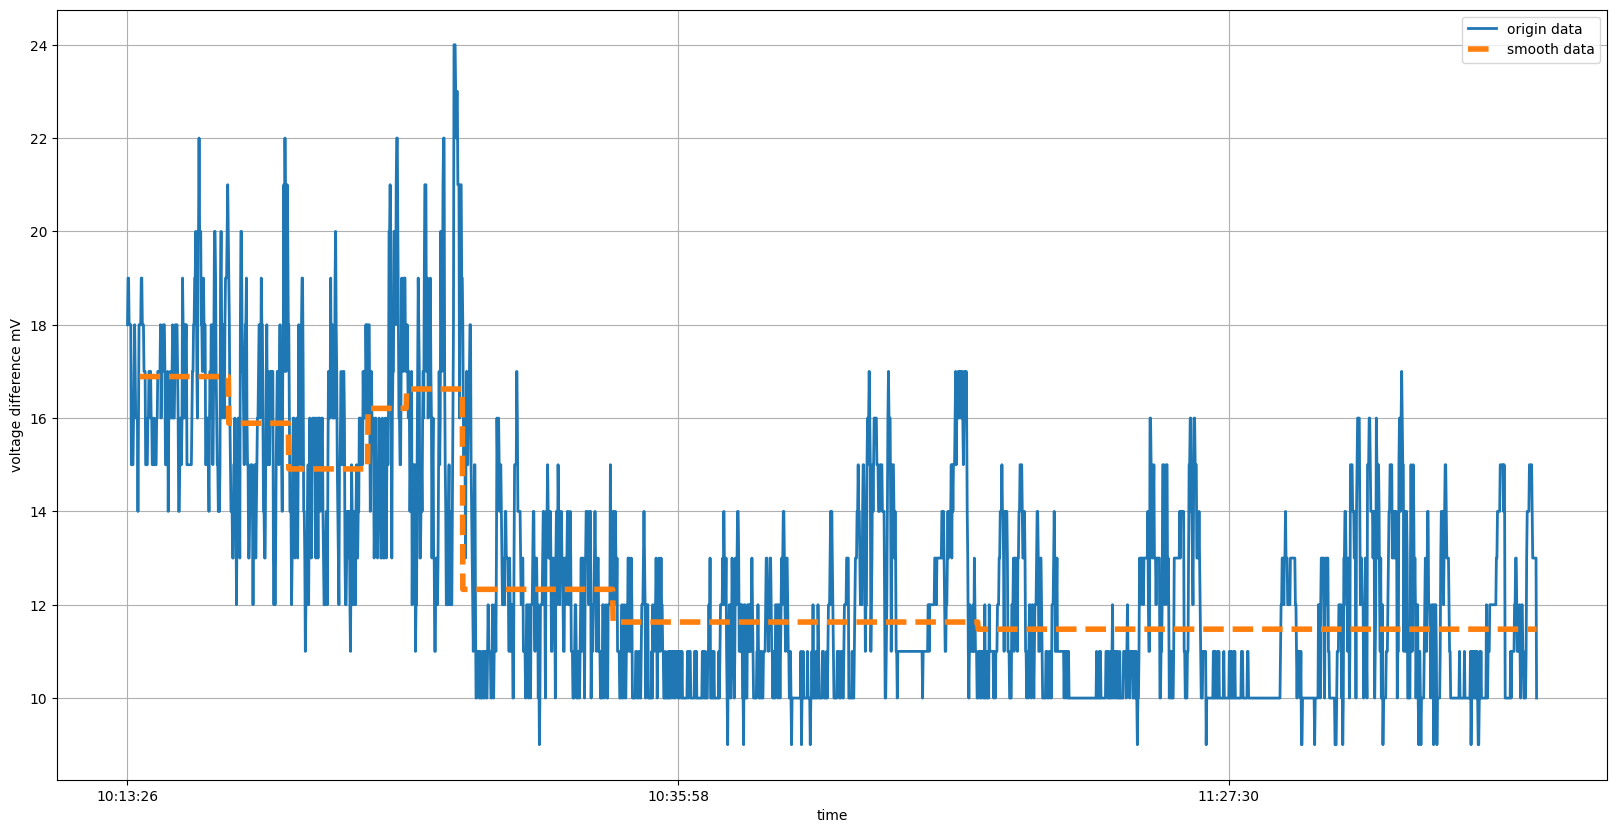

In [172]:
plt.figure(figsize=(20,10))
idx_l = list(range(0, len(tmp)))[::1000]
idx_r = list(tmp['samplingtimesec'][idx_l])
idx_r = [str(x)[11:] for x in idx_r]
plt.xticks(idx_l,idx_r)
plt.xlabel('time')
plt.ylabel('voltage difference mV')
plt.plot(tmp['D135_diff_x'],label="origin data", linewidth=2)
plt.plot(tmp['D135_diff_y'],'--', label="smooth data", linewidth=4)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

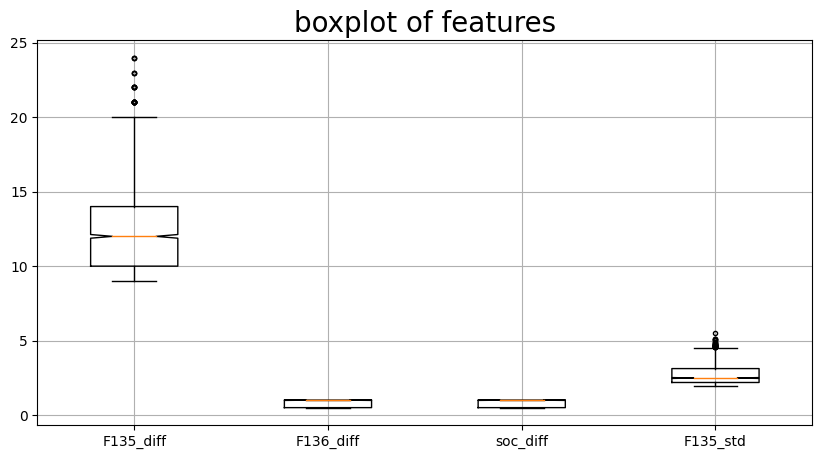

In [184]:
tmp = df.filter((pl.col('cycle')==3) & (pl.col('D24').is_between(50,60))).to_pandas()
box_1, box_2, box_3, box_4 = tmp['D135_diff'],tmp['D136_diff'],tmp['soc_diff'],tmp['D135_std']
plt.figure(figsize=(10,5))
plt.title('boxplot of features',fontsize=20)
labels = ['F135_diff','F136_diff','soc_diff','F135_std']
plt.boxplot([box_1, box_2, box_3, box_4], labels = labels, notch=True, sym='.')
plt.grid(True)
plt.show()

In [201]:
file_path = "processed_data/normal_sample/charge_data"
for file in os.listdir(file_path):
    res[file.split('_')[0]] = pl.read_parquet(os.path.join(file_path,file)).shape[0]

In [202]:
file_path = "processed_data/normal_sample/discharge_data"
for file in os.listdir(file_path):
    res[file.split('_')[0]] += pl.read_parquet(os.path.join(file_path,file)).shape[0]

In [206]:
data = {'car_no':[], 'quantity after processed':[]}
for key,value in res.items():
    data['car_no'].append(key)
    data['quantity after processed'].append(value)

In [207]:
calc_sample_cnt = pl.DataFrame(data)

In [210]:
res = {}
file_path = "data"
for file in os.listdir(file_path):
    res[file.split('_')[0]] = 0
for file in os.listdir(file_path):
    if 'parquet' in file:
        res[file.split('_')[0]] += pl.read_parquet(os.path.join(file_path,file)).shape[0]

In [215]:
tmp=[]
for car in calc_sample_cnt['car_no']:
    tmp.append(res[car])

In [219]:
calc_sample_cnt = calc_sample_cnt.with_columns(quantity_before_processed = pl.Series(tmp))

In [225]:
calc_sample_cnt = calc_sample_cnt.with_columns(((1-pl.col('quantity after processed')/pl.col('quantity_before_processed'))*100).alias("compressibility"))

In [226]:
calc_sample_cnt.write_csv("sample_quantity.csv")

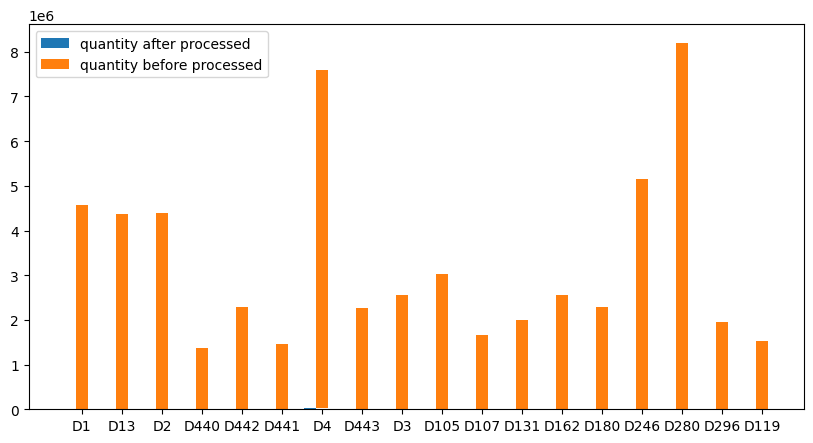

In [222]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
labels = calc_sample_cnt['car_no'].to_list()
left_bottom_data = calc_sample_cnt['quantity after processed'].to_list()
left_top_data = calc_sample_cnt['quantity_before_processed'].to_list()
width = 0.3  # 设置条形图一个长条的宽度
ax.bar(np.arange(len(left_bottom_data)), left_bottom_data, width=width, tick_label=labels, label="quantity after processed")
ax.bar(np.arange(len(left_top_data))+width, left_top_data, bottom=left_bottom_data, width=width, tick_label=labels,
       label="quantity before processed")
ax.legend()
fig.show()

In [ ]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

# 加载Cora数据集
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# 定义一个简单的GCN网络
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, data.batch)
        x = self.conv2(x, edge_index)
        return x

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = torch.nn.functional.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 绘制神经网络结构图
pos = data.get_pos()
x, y = pos[:, 0], pos[:, 1]
plt.scatter(x, y)
for i, (node, attr) in enumerate(data.nodes(data=True)):
    plt.scatter(attr['x'], attr['y'], c='r', marker='o' if node == 1 else 's', s=500 * (i + 1))
    plt.text(attr['x'], attr['y'], str(i + 1), fontsize=12)
plt.show()

In [227]:
df = pl.read_parquet('processed_data/neg_sample/charge_data/D1_4_5.parquet')

In [229]:
df.head()

D141,D22,D24_int,D44,D40,D41,D52,D117,D133,D334,D356,D290,D135_diff,D136_diff,soc_diff,D135_1,D135_2,D135_3,D135_4,D135_5,D135_6,D135_7,D135_8,D135_9,D135_10,D135_11,D135_12,D135_13,D135_14,D135_15,D135_16,D135_17,D135_18,D135_19,D135_20,D135_21,D135_22,…,D135_79_dv,D135_80_dv,D135_81_dv,D135_82_dv,D135_83_dv,D135_84_dv,D135_85_dv,D135_86_dv,D135_87_dv,D135_88_dv,D135_89_dv,D135_90_dv,D135_91_dv,D135_92_dv,D135_93_dv,D135_94_dv,D135_95_dv,D135_96_dv,D135_97_dv,D135_98_dv,D135_99_dv,D135_100_dv,D135_101_dv,D135_102_dv,D135_103_dv,D135_104_dv,D135_105_dv,D135_106_dv,D135_107_dv,D135_108_dv,D135_109_dv,D135_110_dv,D135_111_dv,D135_112_dv,label,cycle,samplingtimesec
f64,f32,f64,f64,f64,f64,f32,f64,f64,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i64
339.19403,-22.38806,23.0,0.0,24.437811,23.159204,14.310946,23.5,2925.0,99.099998,45.606964,405.562195,7.955224,1.0,1.278607,3614.596924,3617.383057,3614.397949,3613.85083,3611.895508,3612.945312,3614.323486,3613.0,3612.218994,3614.139404,3612.02002,3611.955322,3611.616943,3611.855713,3611.393066,3612.711426,3613.781006,3613.621826,3614.462646,3612.795898,3614.965088,3614.358154,…,19.0,18.0,18.0,19.0,18.0,18.0,19.0,19.0,19.0,19.0,19.0,19.0,18.0,18.0,18.0,18.0,19.0,18.0,19.0,18.0,18.0,19.0,19.0,19.0,19.0,18.0,18.0,19.0,18.0,19.0,18.0,18.0,18.0,18.0,0,1,1631019969000
345.870317,-23.395966,24.0,0.0,25.247839,23.926513,14.397118,23.5,2925.0,99.100288,29.760807,406.642639,7.74928,1.0,1.321326,3624.126709,3626.61377,3623.933838,3623.521729,3621.538818,3622.659912,3623.936523,3622.665771,3621.881836,3623.743408,3621.680176,3621.599365,3621.236328,3621.556152,3621.074951,3622.380371,3623.487061,3623.311279,3624.077881,3622.432373,3624.515869,3624.008545,…,10.0,10.0,10.0,10.0,10.0,10.0,9.0,9.0,10.0,9.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,9.0,9.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,1631020174000
355.731988,-23.426802,25.0,0.0,26.231988,24.909222,14.398559,23.5,2925.0,99.100288,26.864553,407.605194,6.351585,1.0,1.322767,3632.2854,3633.861572,3632.112305,3631.815674,3630.224854,3631.291016,3632.086426,3631.022949,3630.484131,3631.907715,3630.429443,3630.253662,3629.910645,3630.337158,3629.959717,3630.867432,3631.752197,3631.824219,3632.30249,3631.213135,3632.61084,3632.314209,…,8.0,7.0,7.0,7.0,6.0,8.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,6.0,7.0,8.0,7.0,7.0,7.0,7.0,8.0,7.0,8.0,8.0,0,1,1631020523000
364.951009,-23.437464,26.0,0.0,27.21902,25.894813,14.398559,23.5,2925.0,99.099998,24.431486,408.21283,4.766571,1.001441,1.324208,3637.994141,3639.089355,3637.803955,3637.605225,3636.423584,3637.343018,3637.818359,3636.89624,3636.599365,3637.582031,3636.683105,3636.368896,3636.164307,3636.541748,3636.484131,3636.853027,3637.524414,3637.803955,3638.046143,3637.492676,3638.2854,3638.054688,…,5.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,0,1,1631020870000
373.536657,-23.448093,27.0,0.0,28.211144,26.88563,14.397947,23.5,2925.0,99.101173,23.40176,408.870972,4.123167,1.315249,1.325513,3642.654053,3643.533691,3642.416504,3642.263916,3641.176025,3642.070312,3642.478027,3641.557129,3641.378418,3642.199463,3641.513184,3641.111328,3640.950195,3641.360596,3641.404785,3641.609863,3642.161377,3642.554199,3642.68042,3642.325439,3642.876953,3642.706787,…,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,0,1,1631021219000


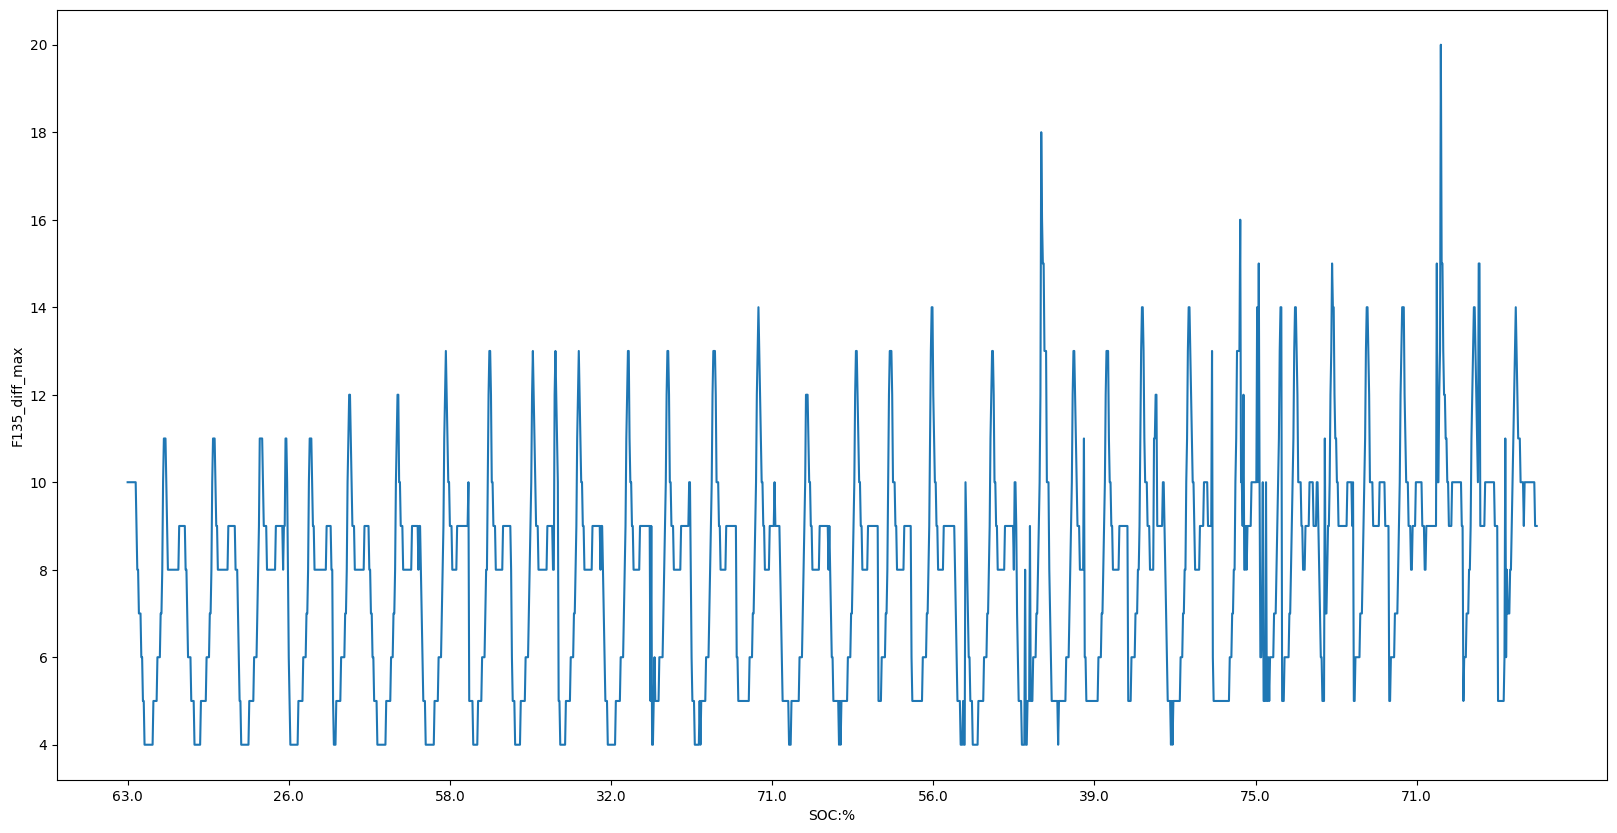

In [241]:
plt.figure(figsize=(20,10))
tmp = df[['D135_diff_max','D24_int']][250:2000]
idx_l = list(range(0, len(tmp)))[::200]
idx_r = [tmp['D24_int'][x] for x in idx_l]
plt.xticks(idx_l,idx_r)
plt.xlabel('SOC:%')
plt.plot(tmp['D135_diff_max'].to_list())
plt.ylabel('F135_diff_max')
# plt.grid(True)
# plt.legend(loc='upper right')
plt.savefig(f"result_plot/prediction_windows.png")
plt.show()